In [1]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from matplotlib import pyplot as plt

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df = spark.read.csv('models/test_results/prophet_results', inferSchema = True, header = True)
df = df.toPandas()
df

,ds,y,cryptocurrency,yhat,yhat_upper,yhat_lower
0,2022-12-06 00:00:39,16973.120000,bitcoin,17052.672653,17504.542764,16628.791170
1,2022-12-06 01:01:43,17053.793000,bitcoin,17063.298213,17489.459934,16640.049405
2,2022-12-06 02:02:20,17052.305000,bitcoin,17074.974324,17517.319180,16665.475351
3,2022-12-06 03:00:58,17045.697000,bitcoin,17084.692627,17532.099197,16607.776972
4,2022-12-06 04:01:33,17010.582000,bitcoin,17092.638430,17533.620189,16642.985129
...,...,...,...,...,...,...
3439,2022-12-29 15:01:26,0.346701,xrp,0.430467,1.055523,-0.140235
3440,2022-12-29 16:01:41,0.345902,xrp,0.430982,1.050901,-0.159956
3441,2022-12-29 17:02:01,0.346928,xrp,0.431421,1.057462,-0.159002
3442,2022-12-29 18:01:09,0.345843,xrp,0.431894,1.052528,-0.163001


In [3]:
print(f'MSE = {mean_squared_error(df.y, df.yhat)}')
print(f'MAE = {mean_absolute_error(df.y, df.yhat)}')
print(f'R2 = {r2_score(df.y, df.yhat)}')

MSE = 291346.39751042466
MAE = 217.75655209363265
R2 = 0.9925424179197567


In [4]:
cryptos = np.unique(df.cryptocurrency)
for crypto in cryptos:
    df_c = df[df.cryptocurrency == crypto]
    print(crypto)
    print(f'MSE = {mean_squared_error(df_c.y, df_c.yhat)}')
    print(f'MAE = {mean_absolute_error(df_c.y, df_c.yhat)}')
    print(f'R2 = {r2_score(df_c.y, df_c.yhat)}')
    print()

bitcoin
MSE = 1693117.1206893206
MAE = 1095.9993711020672
R2 = -15.209211031288447

cardano
MSE = 0.0032329029780348516
MAE = 0.04779888052358996
R2 = -3.7058278480874955

dogecoin
MSE = 0.0032287965883096644
MAE = 0.05143213289418556
R2 = -32.20615877501996

ethereum
MSE = 54953.07142065084
MAE = 208.07961360562268
R2 = -34.212266890217215

solana
MSE = 8.183321277925312
MAE = 2.311257651816226
R2 = -4.277757664224876

xrp
MSE = 0.003169599528002904
MAE = 0.04983918887197665
R2 = -8.5002147882217



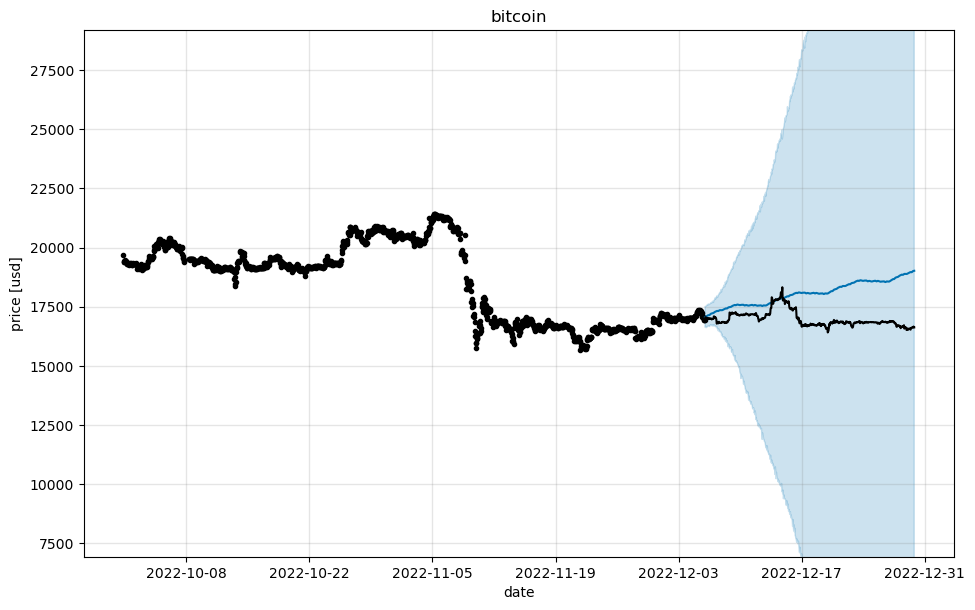

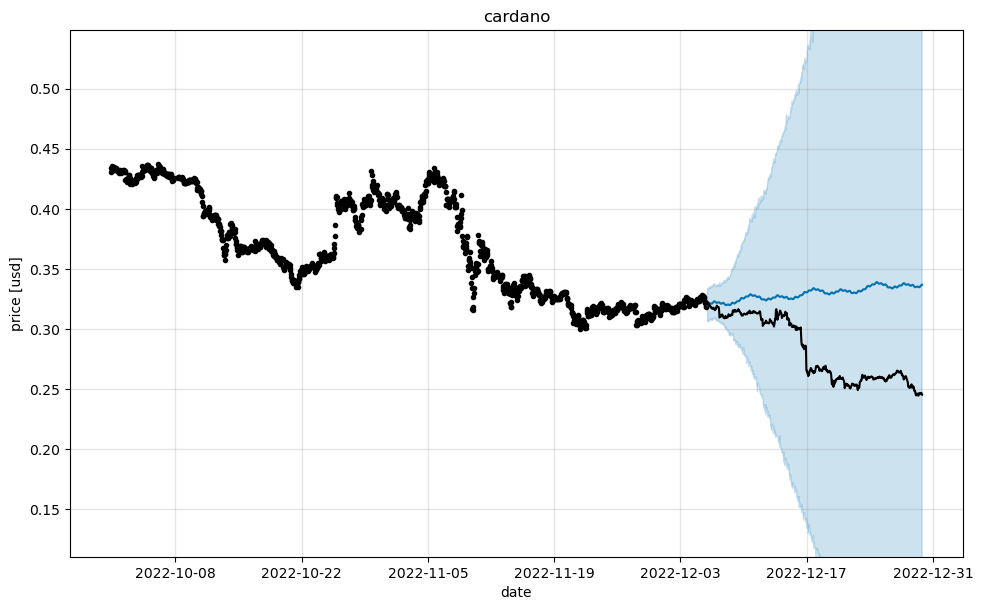

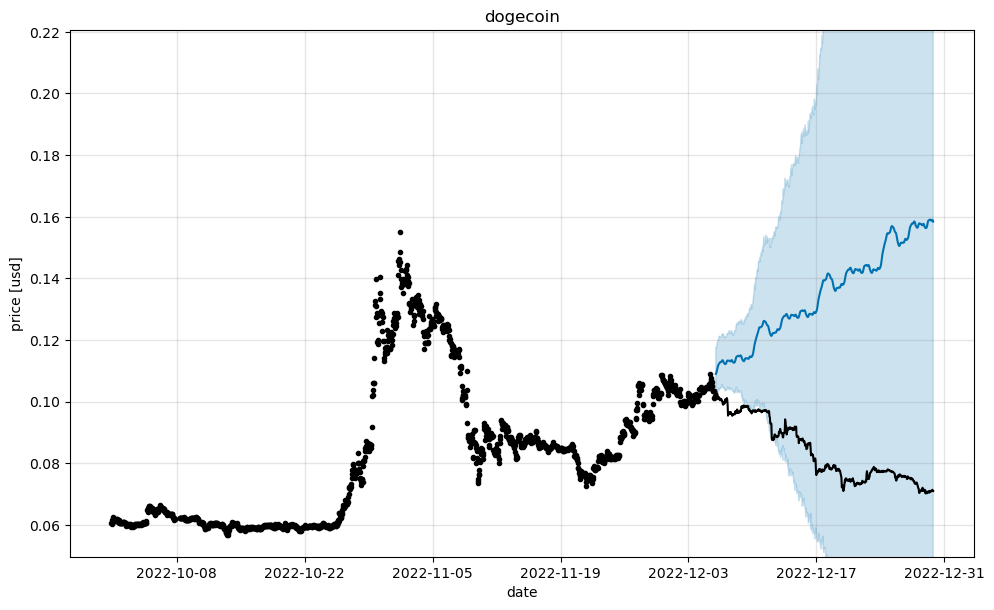

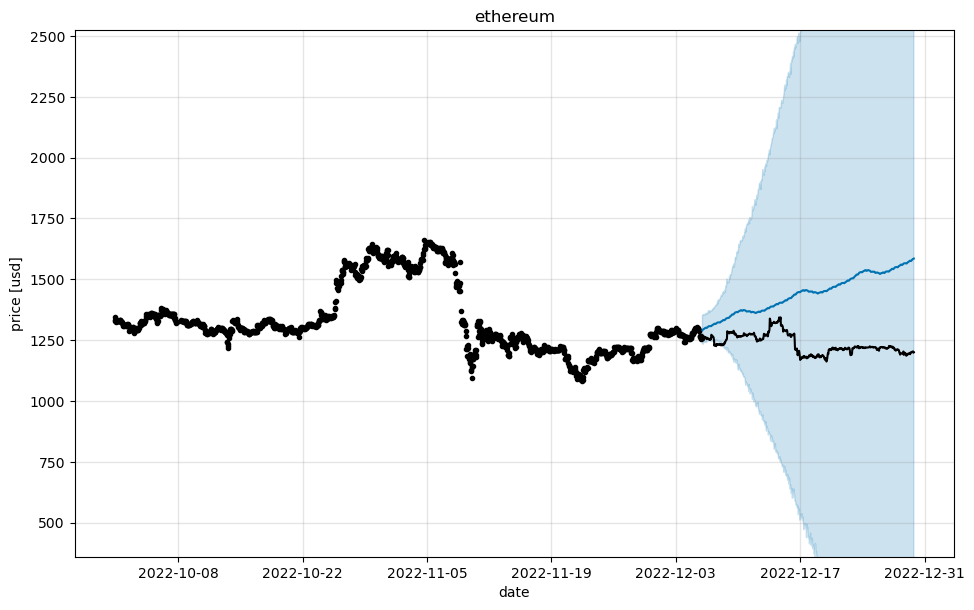

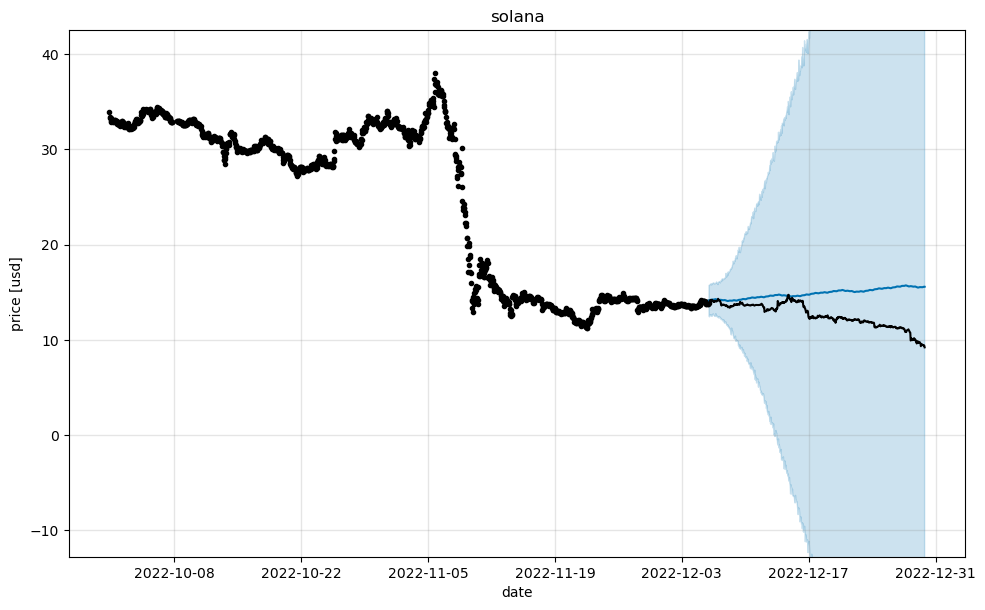

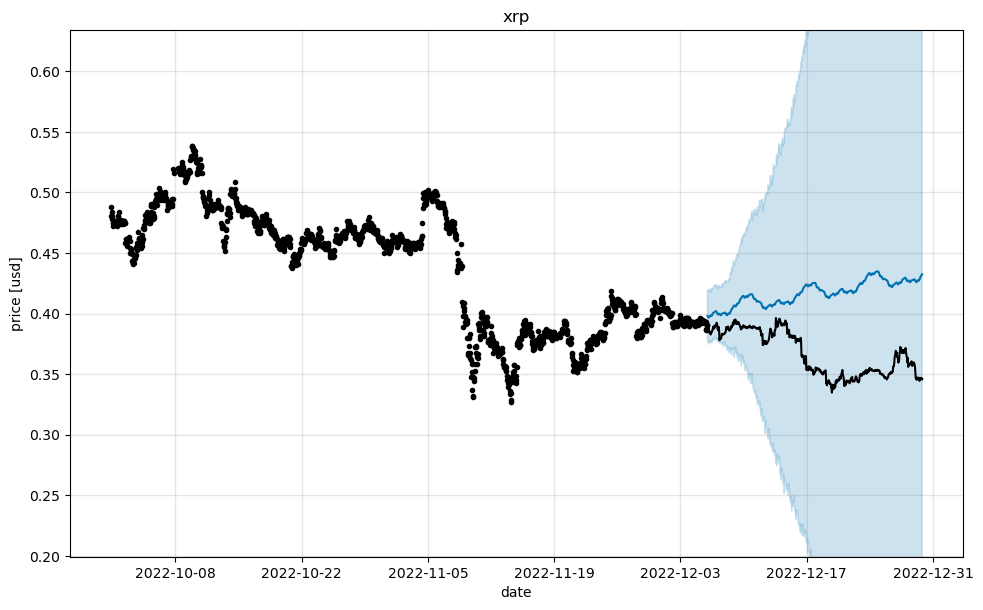

In [6]:
for crypto in cryptos:
    model_path_curr = crypto + '_prophet_model.json'
    cmd = f'hdfs dfs -copyToLocal /user/bda_reddit_pw/models/{model_path_curr} .'
    os.system(cmd)
    with open(model_path_curr, 'r') as fin:
        model = model_from_json(fin.read())
    os.remove(model_path_curr)
    
    df_c = df[df.cryptocurrency == crypto]
    model.plot(df_c)
    plt.plot(df_c.ds, df_c.y, color='black')
    plt.title(crypto)
    plt.xlabel('date')
    plt.ylabel('price [usd]')
    
    avg_y = np.mean(df_c.yhat)
    diff_y = (np.max(df_c.yhat_upper) - avg_y) / 3
    plt.ylim((avg_y - diff_y, avg_y + diff_y))
    plt.show()